In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!apt-get install -y openslide-tools
!pip install openslide-python

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libopenslide0
Suggested packages:
  libtiff-tools
The following NEW packages will be installed:
  libopenslide0 openslide-tools
0 upgraded, 2 newly installed, 0 to remove and 41 not upgraded.
Need to get 104 kB of archives.
After this operation, 297 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libopenslide0 amd64 3.4.1+dfsg-5build1 [89.8 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 openslide-tools amd64 3.4.1+dfsg-5build1 [13.8 kB]
Fetched 104 kB in 0s (498 kB/s)
Selecting previously unselected package libopenslide0.
(Reading database ... 121703 files and directories currently installed.)
Preparing to unpack .../libopenslide0_3.4.1+dfsg-5build1_amd64.deb ...
Unpacking libopenslide0 (3.4.1+dfsg-5build1) ...
Selecting previously unselected package openslide-tools.

In [ ]:
import openslide
from openslide import open_slide
from openslide.deepzoom import DeepZoomGenerator
import numpy as np
import cv2
from PIL import Image
import os
import sys
import xml.etree.ElementTree as ET
from shapely.geometry import Point, Polygon
import time
import re

In [ ]:
# Dodajemy ścieżkę do pliku .py na Dysku Google
GOOGLE_DRIVE_HELPER_PATH = "/content/drive/MyDrive/PKG-Post-NAT-BRCA"
sys.path.append(GOOGLE_DRIVE_HELPER_PATH)

In [ ]:
from normalize_HnE import norm_HnE

In [ ]:

# --- Ścieżki ---
DATA_ROOT = "/content/drive/MyDrive/PKG-Post-NAT-BRCA"
# Główny folder wyjściowy na Dysku Google
OUTPUT_ROOT_ON_DRIVE = "/content/drive/MyDrive/PKG-Post-NAT-BRCA/Processed_BRCA_Data_TEST_DS"

In [ ]:
# Konfiguracja kafelkowania
TILE_SIZE = 256
OVERLAP = 0
TARGET_LEVEL = 16 # Użyjemy slide.level_count - 1 dla pewności

In [ ]:
# Parametry filtra tła
MAX_MEAN_THRESHOLD = 230
MIN_STD_THRESHOLD = 15

In [ ]:
def has_tissue(tile_image: Image.Image) -> bool:
    """Sprawdza, czy kafelek zawiera tkankę (a nie puste tło)."""
    try:
        tile_np = np.array(tile_image.convert('L'))
        mean_val = np.mean(tile_np)
        std_val = np.std(tile_np)

        if mean_val < MAX_MEAN_THRESHOLD and std_val > MIN_STD_THRESHOLD:
            return True
        else:
            return False
    except Exception as e:
        print(f"Błąd w has_tissue: {e}")
        return False

In [ ]:
def get_label_from_description(desc: str) -> str:
    """
    Interpretuje atrybut 'description' z pliku XML.
    Zwraca 'healthy', 'tumor' lub 'ignore'.
    """
    if not desc:
        return "ignore"

    desc = desc.lower()

    # Szukamy wzorca "Cellularity: X(%)" lub "TB- X%"
    match = re.search(r"(cellula.*:|tb-)\s*(\d+)", desc)

    if match:
        try:
            cellularity = int(match.group(2))
            if cellularity == 0:
                return "healthy"
            elif cellularity > 0:
                return "tumor"
        except Exception:
            pass # Ignoruj błąd parsowania

    # Sprawdzenie etykiet tekstowych (z opisu "White")
    if "healthy" in desc or "normal epithelial" in desc:
        return "healthy"

    if "malignant" in desc or "idc" in desc or "dcis" in desc:
        return "tumor"

    return "ignore" # Ignoruj inne, np. Lymphocyte

In [ ]:
def parse_xml_annotations(xml_path: str) -> list:
    """
    Parsuje plik .xml Sedeen i zwraca listę poligonów z etykietami.
    Zwraca: [(Shapely_Polygon, 'etykieta_folderu'), ...]
    """
    polygons = []
    try:
        tree = ET.parse(xml_path)
        root = tree.getroot()

        # Zaktualizowana ścieżka do tagów <graphic>
        for graphic in root.findall(".//graphic"):
            description = graphic.get("description")

            # Mapujemy etykietę XML na naszą etykietę folderu ('healthy', 'tumor', 'ignore')
            mapped_label = get_label_from_description(description)

            if mapped_label == "ignore":
                continue

            # Znajdź wszystkie współrzędne dla tego regionu
            coordinates = []
            for coord in graphic.findall(".//point"):
                x = float(coord.text.split(',')[0])
                y = float(coord.text.split(',')[1])
                coordinates.append((x, y))

            if len(coordinates) >= 3:
                polygons.append((Polygon(coordinates), mapped_label))

    except Exception as e:
        print(f"Błąd podczas parsowania XML {xml_path}: {e}")

    return polygons

In [ ]:
def run_single_scan_test(scan_folder: str, scan_name: str, output_dir: str) -> (int, int):
    """
    Uruchamia pełny potok przetwarzania dla JEDNEGO skanu.
    Zwraca (liczbę zapisanych 'healthy', liczbę zapisanych 'tumor')
    """

    print(f"\n=======================================================")
    print(f"Rozpoczynam przetwarzanie skanu: {scan_name}")
    print(f"=======================================================")

    scan_path = os.path.join(scan_folder, f"{scan_name}.svs")
    xml_path = os.path.join(scan_folder, "sedeen", f"{scan_name}.session.xml")

    scan_specific_output_dir = os.path.join(output_dir, scan_name)
    os.makedirs(os.path.join(scan_specific_output_dir, "healthy"), exist_ok=True)
    os.makedirs(os.path.join(scan_specific_output_dir, "tumor"), exist_ok=True)

    # --- 1. Wczytaj Adnotacje ---
    if not os.path.exists(xml_path):
        print(f"BŁĄD: Nie znaleziono pliku XML: {xml_path}")
        return 0, 0 # Zwróć zero, jeśli plik nie istnieje

    polygons = parse_xml_annotations(xml_path)
    if not polygons:
        print(f"BŁĄD: Nie znaleziono adnotacji w pliku XML dla skanu {scan_name}.")
        return 0, 0
    print(f" Znaleziono {len(polygons)} adnotacji (poligonów) w pliku XML.")

    # --- 2. Wczytaj Skan ---
    try:
        slide = openslide.open_slide(scan_path)
        tiles = DeepZoomGenerator(slide, tile_size=TILE_SIZE, overlap=OVERLAP, limit_bounds=False)
        current_target_level = tiles.level_count - 1
        cols, rows = tiles.level_tiles[current_target_level]
        print(f"Skan wczytany. Przetwarzam poziom {current_target_level} (siatka: {cols}x{rows}).")
    except Exception as e:
        print(f"BŁĄD: Nie można otworzyć pliku SVS {scan_path}: {e}.")
        return 0, 0

    # --- 3. Pętla po Kafelkach ---
    tiles_saved_healthy = 0
    tiles_saved_tumor = 0
    tiles_processed = 0

    print("⏳ Rozpoczynam skanowanie kafelków... (to potrwa długo)")

    for row in range(rows):
        for col in range(cols):
            try:
                tiles_processed += 1
                tile_image = tiles.get_tile(current_target_level, (col, row))

                if not has_tissue(tile_image):
                    continue

                level_0_coords = tiles.get_tile_coordinates(current_target_level, (col, row))[0]
                tile_center_point = Point(level_0_coords[0] + (TILE_SIZE // 2), level_0_coords[1] + (TILE_SIZE // 2))

                tile_label = "unknown"
                for polygon, label in polygons:
                    if tile_center_point.within(polygon):
                        tile_label = label
                        break

                if tile_label == "unknown":
                    continue

                tile_np = np.array(tile_image.convert('RGB'))
                norm_img_np, _, _ = norm_HnE(tile_np)
                norm_img_pil = Image.fromarray(norm_img_np)

                tile_filename = f"{scan_name}_L{current_target_level}_{col}_{row}.png"

                # Zmodyfikowana logika zapisu i liczenia
                if tile_label == 'healthy':
                    save_path = os.path.join(scan_specific_output_dir, "healthy", tile_filename)
                    tiles_saved_healthy += 1
                else:
                    save_path = os.path.join(scan_specific_output_dir, "tumor", tile_filename)
                    tiles_saved_tumor += 1

                norm_img_pil.save(save_path)

            except Exception as e:
                pass # Ignoruj błędy RuntimeWarning i błędy geometrii

        # Logowanie postępów co 10 wierszy
        if (row + 1) % 10 == 0:
            print(f"    ...przetworzono {row+1}/{rows} wierszy. [Zapisano H: {tiles_saved_healthy} | T: {tiles_saved_tumor}]")

    print(f"\n=======================================================")
    print(f"Zakończono skanowanie: {scan_name}")
    print(f"Łącznie przetworzono kafelków: {tiles_processed}")
    print(f"Łącznie zapisano kafelków: {tiles_saved_healthy + tiles_saved_tumor}")
    print(f"   -> Healthy: {tiles_saved_healthy}")
    print(f"   -> Tumor: {tiles_saved_tumor}")
    print(f"Sprawdź folder: {scan_specific_output_dir}")
    print(f"=======================================================")
    return tiles_saved_healthy, tiles_saved_tumor

MAIN DLA TRAIN DATA


In [ ]:
def main():
    """
    Główna funkcja, która zarządza całą serią przetwarzania.
    """
    SCANS_TO_PROCESS = [

        ("99826", "WSI_train3"),
        ("99834", "WSI_train3"),
        ("99835", "WSI_train3"),
        ("99836", "WSI_train3"),
    ]

    print(f"Znaleziono {len(SCANS_TO_PROCESS)} skanów do przetworzenia w tej sesji.")

    total_batch_healthy = 0
    total_batch_tumor = 0
    start_batch_time = time.time()


    # Pętla po wszystkich skanach z listy
    for i, (scan_id, folder_name) in enumerate(SCANS_TO_PROCESS):
        print(f"\n\n--- ROZPOCZYNAM SKAN {i+1}/{len(SCANS_TO_PROCESS)}: [ {scan_id} ] ---")

        scan_start_time = time.time()

        try:
            # Pełna ścieżka do folderu nadrzędnego tego skanu
            scan_folder_path = os.path.join(DATA_ROOT, "WSI_train", folder_name)

            # Główna funkcja przetwarzania
            h_count, t_count = run_single_scan_test(
                scan_folder=scan_folder_path,
                scan_name=scan_id,
                output_dir=OUTPUT_ROOT_ON_DRIVE
            )

            # Dodaj wyniki do sumy całej sesji
            total_batch_healthy += h_count
            total_batch_tumor += t_count

        except Exception as e:
            print(f"BŁĄD KRYTYCZNY przy przetwarzaniu {scan_id}: {e}")
            print("Przechodzę do następnego skanu...")

        scan_end_time = time.time()
        print(f"--- ZAKOŃCZONO SKAN [ {scan_id} ] w {(scan_end_time - scan_start_time) / 60:.2f} minut. ---")

    # --- Ostateczne podsumowanie całej sesji ---
    end_batch_time = time.time()
    print("\n\n#########################################################")
    print("=======ZAKOŃCZONO CAŁĄ SERIĘ PRZETWARZANIA =======")
    print("#########################################################")
    print(f"Łączny czas przetwarzania tej sesji: {(end_batch_time - start_batch_time) / 60:.2f} minut.")
    print("\n--- ŁĄCZNE PODSUMOWANIE ZAPISANYCH KAFELKÓW ---")
    print(f"Łącznie zapisano 'healthy': {total_batch_healthy}")
    print(f"Łącznie zapisano 'tumor':   {total_batch_tumor}")
    print(f"Całkowita liczba kafelków: {total_batch_healthy + total_batch_tumor}")

MAIN DLA TEST DATA

In [ ]:
# ====================================================================
#  KROK 4: GŁÓWNA PĘTLA ZARZĄDZAJĄCA (Wersja dla folderu TEST)
# ====================================================================

def main_test():
    """
    Główna funkcja, która zarządza całą serią przetwarzania.
    Wersja dla folderu 'test' z RĘCZNĄ listą skanów.
    """

    # -----------------------------------------------------------------
    #  KONFIGURACJA ŚCIEŻEK DLA DANYCH TESTOWYCH
    # -----------------------------------------------------------------

    # Główny folder z danymi testowymi (gdzie są pliki .svs i folder 'sedeen')
    TEST_DATA_DIR = "/content/drive/MyDrive/PKG-Post-NAT-BRCA/test"

    # -----------------------------------------------------------------
    #  TUTAJ WPISZ LISTĘ SKANÓW TESTOWYCH DO PRZETWORZENIA
    #  (Tylko nazwy skanów, bez folderów nadrzędnych)
    # -----------------------------------------------------------------
    SCANS_TO_PROCESS = [
        "102195",
        "102563",
    ]

    print(f"Znaleziono {len(SCANS_TO_PROCESS)} skanów do przetworzenia w tej sesji.")

    total_batch_healthy = 0
    total_batch_tumor = 0
    start_batch_time = time.time()

    # Montowanie Dysku Google
    try:
        drive.mount('/content/drive', force_remount=True)
        print("\n Dysk Google zamontowany.")

        # Sprawdzenie, czy globalna zmienna wyjściowa jest dostępna
        if 'OUTPUT_ROOT_ON_DRIVE' not in globals():
            print("BŁĄD KRYTYCZNY: Zmienna 'OUTPUT_ROOT_ON_DRIVE' nie jest zdefiniowana w poprzedniej komórce!")
            return

        # Upewnij się, że folder wyjściowy istnieje (używając zmiennej globalnej)
        os.makedirs(OUTPUT_ROOT_ON_DRIVE, exist_ok=True)

    except Exception as e:
        print(f"BŁĄD KRYTYCZNY: Nie udało się zamontować Dysku Google: {e}. Przerywam.")
        return

    # Pętla po wszystkich skanach z listy
    for i, scan_id in enumerate(SCANS_TO_PROCESS):
        print(f"\n\n--- ROZPOCZYNAM SKAN {i+1}/{len(SCANS_TO_PROCESS)}: [ {scan_id} ] ---")

        scan_start_time = time.time()

        try:
            # Używamy TEST_DATA_DIR jako 'scan_folder'.
            # Funkcja run_single_scan_test (Krok 3) automatycznie
            # zbuduje poprawne ścieżki:
            # scan_path = .../test/99826.svs
            # xml_path = .../test/sedeen/99826.session.xml

            h_count, t_count = run_single_scan_test(
                scan_folder=TEST_DATA_DIR,  # <-- Ścieżka bazowa do folderu 'test'
                scan_name=scan_id,
                output_dir=OUTPUT_ROOT_ON_DRIVE # <-- Użycie Twojej zmiennej globalnej
            )

            # Dodaj wyniki do sumy całej sesji
            total_batch_healthy += h_count
            total_batch_tumor += t_count

        except Exception as e:
            print(f"BŁĄD KRYTYCZNY przy przetwarzaniu {scan_id}: {e}")
            print("Przechodzę do następnego skanu...")

        scan_end_time = time.time()
        print(f"--- ZAKOŃCZONO SKAN [ {scan_id} ] w {(scan_end_time - scan_start_time) / 60:.2f} minut. ---")

    # --- Ostateczne podsumowanie całej sesji ---
    end_batch_time = time.time()
    print("\n\n#########################################################")
    print("==========ZAKOŃCZONO CAŁĄ SERIĘ PRZETWARZANIA=========")
    print("#########################################################")
    print(f"Łączny czas przetwarzania tej sesji: {(end_batch_time - start_batch_time) / 60:.2f} minut.")
    print("\n--- ŁĄCZNE PODSUMOWANIE ZAPISANYCH KAFELKÓW ---")
    print(f"Łącznie zapisano 'healthy': {total_batch_healthy}")
    print(f"Łącznie zapisano 'tumor':   {total_batch_tumor}")
    print(f"Całkowita liczba kafelków: {total_batch_healthy + total_batch_tumor}")

In [ ]:
if __name__ == "__main__":
    main_test()

Znaleziono 2 skanów do przetworzenia w tej sesji.
Mounted at /content/drive

✅ Dysk Google zamontowany.


--- ROZPOCZYNAM SKAN 1/2: [ 102195 ] ---

🚀 Rozpoczynam przetwarzanie skanu: 102195
✅ Znaleziono 66 adnotacji (poligonów) w pliku XML.
✅ Skan wczytany. Przetwarzam poziom 16 (siatka: 220x140).
⏳ Rozpoczynam skanowanie kafelków... (to potrwa długo)
    ...przetworzono 10/140 wierszy. [Zapisano H: 0 | T: 0]
    ...przetworzono 20/140 wierszy. [Zapisano H: 10 | T: 0]
    ...przetworzono 30/140 wierszy. [Zapisano H: 22 | T: 0]
    ...przetworzono 40/140 wierszy. [Zapisano H: 52 | T: 0]
    ...przetworzono 50/140 wierszy. [Zapisano H: 68 | T: 0]
    ...przetworzono 60/140 wierszy. [Zapisano H: 84 | T: 0]
    ...przetworzono 70/140 wierszy. [Zapisano H: 90 | T: 2]
    ...przetworzono 80/140 wierszy. [Zapisano H: 100 | T: 24]
    ...przetworzono 90/140 wierszy. [Zapisano H: 108 | T: 48]
    ...przetworzono 100/140 wierszy. [Zapisano H: 124 | T: 76]
    ...przetworzono 110/140 wierszy. [Za

ANALIZA DANYCH


In [ ]:
# ====================================================================
#  KROK 0: INSTALACJA PAKIETU DO CZYTANIA EXCELA
# ====================================================================
print("⏳ Instalowanie biblioteki 'openpyxl' do czytania plików .xlsx...")
!pip install openpyxl -q
print("✅ Gotowe.")

import os
import xml.etree.ElementTree as ET
import re
import pandas as pd
from google.colab import drive

# ====================================================================
#  KROK 1: KONFIGURACJA
# ====================================================================

# Upewnij się, że te ścieżki są poprawne!

# Główny folder z danymi na Dysku Google
DATA_ROOT = "/content/drive/MyDrive/PKG-Post-NAT-BRCA"

# Pełna ścieżka do pliku Excel .xlsx
# <-- ZMIANA TUTAJ (poprawna nazwa pliku)
CLINICAL_FEATURES_FILE = "/content/drive/MyDrive/PKG-Post-NAT-BRCA/FINAL-BreastPathQ_TrainTest_Clinical_Features.xlsx"

# Nazwa arkusza w pliku Excel, który zawiera dane
# <-- ZMIANA TUTAJ (na podstawie nazwy pliku, który wgrałeś)
SHEET_NAME = "Clinical Features"

# Foldery, które chcesz przeskanować
FOLDERS_TO_AUDIT = ['test']

# Nasz regex do znajdowania komórkowości
CELLULARITY_REGEX = re.compile(r"(cellula.*:|tb-)\s*(\d+)")

# ====================================================================
#  KROK 2: FUNKCJE POMOCNICZE
# ====================================================================

def load_patient_map(excel_path: str, sheet: str) -> dict:
    """Wczytuje plik Excel i tworzy mapę {scan_id: patient_id}."""
    patient_map = {}
    try:
        # <-- ZMIANA TUTAJ (używamy pd.read_excel i nazwy arkusza)
        df = pd.read_excel(excel_path, sheet_name=sheet)

        # Usuwamy spacje z nazw kolumn dla bezpieczeństwa
        df.columns = df.columns.str.strip()

        if 'scan ID' not in df.columns or 'patient ID' not in df.columns:
            print(f"🟥 BŁĄD: W pliku Excel (arkusz '{sheet}') brakuje kolumn 'scan ID' lub 'patient ID'.")
            return {}

        # Tworzymy mapę, konwertując ID na stringi dla spójności
        for _, row in df.iterrows():
            # Pomijamy wiersze, gdzie brakuje scan ID
            if pd.isna(row['scan ID']):
                continue

            # Konwertujemy scan ID na string bez .0 (jeśli jest liczbą)
            scan_id_str = str(row['scan ID']).split('.')[0]
            patient_map[scan_id_str] = str(row['patient ID'])

        print(f"✅ Pomyślnie wczytano mapę pacjentów dla {len(patient_map)} skanów.")

    except FileNotFoundError:
        print(f"🟥 BŁĄD KRYTYCZNY: Nie znaleziono pliku Excel pod ścieżką: {excel_path}")
        print("Upewnij się, że ścieżka CLINICAL_FEATURES_FILE jest poprawna.")
    except Exception as e:
        if "No sheet named" in str(e):
             print(f"🟥 BŁĄD KRYTYCZNY: Nie znaleziono arkusza '{sheet}' w pliku Excel.")
        else:
             print(f"🟥 BŁĄD: Nie można wczytać pliku Excel: {e}")

    return patient_map

def analyze_xml(xml_path: str) -> (int, int):
    """
    Parsuje jeden plik XML i zlicza regiony 'healthy' i 'tumor'.
    Zwraca: (healthy_count, tumor_count)
    """
    healthy_count = 0
    tumor_count = 0

    try:
        tree = ET.parse(xml_path)
        root = tree.getroot()

        for graphic in root.findall(".//graphic"):
            desc = graphic.get("description")

            if not desc:
                continue # Pomiń region bez opisu

            match = CELLULARITY_REGEX.search(desc.lower())

            if match:
                try:
                    cellularity = int(match.group(2)) # Pobierz liczbę

                    if cellularity == 0:
                        healthy_count += 1
                    else: # (cellularity > 0)
                        tumor_count += 1
                except Exception:
                    pass # Ignoruj błąd konwersji liczby

    except Exception as e:
        print(f"Błąd podczas parsowania {xml_path}: {e}")

    return healthy_count, tumor_count

# ====================================================================
#  KROK 3: GŁÓWNA LOGIKA AUDYTU
# ====================================================================

def run_audit():
    """Główna funkcja uruchamiająca audyt."""

    print("Rozpoczynam audyt zrównoważenia danych...")

    # 1. Zamontuj Dysk Google
    try:
        drive.mount('/content/drive', force_remount=True)
    except Exception as e:
        print(f"Nie udało się zamontować Dysku Google: {e}")
        return

    # 2. Wczytaj mapę pacjentów
    # <-- ZMIANA TUTAJ (przekazujemy też nazwę arkusza)
    patient_map = load_patient_map(CLINICAL_FEATURES_FILE, SHEET_NAME)
    if not patient_map:
        print("Audyt zatrzymany z powodu braku danych o pacjentach.")
        return

    # 3. Przetwórz każdy folder
    for folder_name in FOLDERS_TO_AUDIT:
        print(f"\n--- Analizuję folder: {folder_name} ---")

        sedeen_dir = os.path.join(DATA_ROOT, "test", "sedeen")

        if not os.path.exists(sedeen_dir):
            print(f"⚠️ Ostrzeżenie: Nie znaleziono folderu 'sedeen' w {folder_name}.")
            continue

        # Sortujemy pliki, aby wynik był uporządkowany
        xml_files = sorted([f for f in os.listdir(sedeen_dir) if f.endswith('.session.xml')])

        if not xml_files:
            print(f"Brak plików .session.xml w {sedeen_dir}")
            continue

        for xml_file in xml_files:
            scan_id = xml_file.split('.session.xml')[0]
            xml_path = os.path.join(sedeen_dir, xml_file)

            healthy, tumor = analyze_xml(xml_path)

            # Pobierz ID pacjenta z mapy (z obsługą błędu, jeśli brakuje)
            patient_id = patient_map.get(scan_id, "???")

            # Wypisz wynik w żądanym formacie
            print(f"skan {scan_id} (Pacjent {patient_id}): {healthy} healthy | {tumor} tumor")

# ====================================================================
#  KROK 4: URUCHOMIENIE
# ====================================================================

if __name__ == "__main__":
    run_audit()

⏳ Instalowanie biblioteki 'openpyxl' do czytania plików .xlsx...
✅ Gotowe.
Rozpoczynam audyt zrównoważenia danych...
Mounted at /content/drive
✅ Pomyślnie wczytano mapę pacjentów dla 96 skanów.

--- Analizuję folder: test ---
skan 102174 (Pacjent 37): 8 healthy | 38 tumor
skan 102175 (Pacjent 38): 7 healthy | 42 tumor
skan 102176 (Pacjent 38): 12 healthy | 30 tumor
skan 102177 (Pacjent 38): 12 healthy | 31 tumor
skan 102178 (Pacjent 39): 9 healthy | 39 tumor
skan 102179 (Pacjent 40): 0 healthy | 18 tumor
skan 102180 (Pacjent 41): 9 healthy | 29 tumor
skan 102181 (Pacjent 42): 4 healthy | 36 tumor
skan 102182 (Pacjent 42): 8 healthy | 30 tumor
skan 102183 (Pacjent 43): 10 healthy | 34 tumor
skan 102184 (Pacjent 43): 25 healthy | 35 tumor
skan 102185 (Pacjent 44): 15 healthy | 30 tumor
skan 102186 (Pacjent ???): 0 healthy | 0 tumor
skan 102187 (Pacjent 44): 15 healthy | 25 tumor
skan 102188 (Pacjent 45): 14 healthy | 28 tumor
skan 102189 (Pacjent 46): 0 healthy | 20 tumor
skan 102190 (Pa

In [ ]:
import os
from google.colab import drive
import time

# ====================================================================
#  KONFIGURACJA
# ====================================================================

# 1. Główny folder, w którym znajdują się foldery z nazwami skanów
MAIN_DATA_DIR = "/content/drive/MyDrive/PKG-Post-NAT-BRCA/Processed_BRCA_Data_TEST"

# 2. Folder, który chcesz POMINĄĆ w liczeniu
FOLDER_TO_EXCLUDE = "99788"

# ====================================================================
#  LOGIKA SKRYPTU
# ====================================================================

def count_tiles(base_dir: str, exclude_folder: str):
    """
    Liczy pliki w podfolderach 'healthy' i 'tumor', ignorując jeden
    wskazany folder.
    """

    print(f"Rozpoczynam liczenie plików w: {base_dir}")
    print(f"Ignorowany folder: {exclude_folder}\n")

    total_healthy_files = 0
    total_tumor_files = 0

    # 1. Zamontuj Dysk Google
    try:
        drive.mount('/content/drive', force_remount=True)
    except Exception as e:
        print(f"🟥 BŁĄD: Nie udało się zamontować Dysku Google: {e}")
        return

    # 2. Sprawdź, czy główny folder istnieje
    if not os.path.exists(base_dir):
        print(f"🟥 BŁĄD: Nie znaleziono głównego folderu: {base_dir}")
        return

    # 3. Przejdź przez wszystkie foldery ze skanami
    try:
        scan_folders = os.listdir(base_dir)
    except Exception as e:
        print(f"🟥 BŁĄD: Nie można odczytać zawartości folderu {base_dir}: {e}")
        return

    processed_folders = 0

    for scan_name in scan_folders:
        # Sprawdź, czy to folder do pominięcia
        if scan_name == exclude_folder:
            print(f"--- Pomijam folder: {scan_name} (zgodnie z poleceniem) ---")
            continue

        scan_path = os.path.join(base_dir, scan_name)

        # Upewnij się, że to na pewno folder
        if not os.path.isdir(scan_path):
            continue

        # Zdefiniuj ścieżki do folderów healthy i tumor
        healthy_path = os.path.join(scan_path, "healthy")
        tumor_path = os.path.join(scan_path, "tumor")

        current_healthy = 0
        current_tumor = 0

        # Policz pliki w 'healthy'
        try:
            if os.path.exists(healthy_path):
                # os.listdir() jest szybsze niż chodzenie plik po pliku
                num_files = len(os.listdir(healthy_path))
                current_healthy = num_files
                total_healthy_files += num_files
        except Exception as e:
            print(f"Błąd przy liczeniu w {healthy_path}: {e}")

        # Policz pliki w 'tumor'
        try:
            if os.path.exists(tumor_path):
                num_files = len(os.listdir(tumor_path))
                current_tumor = num_files
                total_tumor_files += num_files
        except Exception as e:
            print(f"Błąd przy liczeniu w {tumor_path}: {e}")

        if current_healthy > 0 or current_tumor > 0:
             print(f"Skan {scan_name}: {current_healthy} healthy | {current_tumor} tumor")
             processed_folders += 1

    # 4. Wyświetl ostateczny raport
    print("\n=======================================================")
    print("🎉 Liczenie zakończone.")
    print(f"Przeanalizowano łącznie {processed_folders} folderów skanów (oprócz {exclude_folder}).")
    print("\n--- WYNIKI CAŁKOWITE ---")
    print(f"🔵 Łączna liczba plików 'healthy': {total_healthy_files}")
    print(f"🔴 Łączna liczba plików 'tumor':   {total_tumor_files}")
    print("=======================================================")

# ====================================================================
#  URUCHOMIENIE
# ====================================================================
if __name__ == "__main__":
    start_time = time.time()
    count_tiles(base_dir=MAIN_DATA_DIR, exclude_folder=FOLDER_TO_EXCLUDE)
    end_time = time.time()
    print(f"\nCałkowity czas wykonania skryptu: {(end_time - start_time):.2f} sekund.")

Rozpoczynam liczenie plików w: /content/drive/MyDrive/PKG-Post-NAT-BRCA/Processed_BRCA_Data_TEST
Ignorowany folder: 99788

Mounted at /content/drive
Skan 99808: 188 healthy | 58 tumor
Skan 99793: 180 healthy | 131 tumor
Skan 99797: 152 healthy | 212 tumor
Skan 99798: 24 healthy | 570 tumor
Skan 99800: 46 healthy | 32 tumor
Skan 99801: 16 healthy | 92 tumor
Skan 99802: 44 healthy | 0 tumor
Skan 99803: 0 healthy | 80 tumor
Skan 99806: 15 healthy | 113 tumor
Skan 99811: 32 healthy | 204 tumor
Skan 99813: 8 healthy | 173 tumor
Skan 99840: 78 healthy | 94 tumor
Skan 99841: 94 healthy | 188 tumor
Skan 99842: 118 healthy | 168 tumor
Skan 99843: 72 healthy | 173 tumor
Skan 99844: 64 healthy | 178 tumor
Skan 99807: 56 healthy | 67 tumor
Skan 99794: 56 healthy | 140 tumor
Skan 99848: 46 healthy | 104 tumor
Skan 99849: 20 healthy | 90 tumor
Skan 99851: 24 healthy | 144 tumor
Skan 99852: 24 healthy | 144 tumor
Skan 99854: 32 healthy | 131 tumor
Skan 99858: 28 healthy | 100 tumor
Skan 99860: 64 hea

Wizualizacja regionów




⏳ Instalowanie zależności...
✅ Gotowe.
Rozpoczynam wizualizację...
Mounted at /content/drive
Wczytuję skan i tworzę miniaturę...
Pełna rozdzielczość: (53783, 47302)
Rozmiar miniatury: (1500, 1319)
Współczynnik skali: 35.86x
Wczytuję i skaluję adnotacje XML...
Znaleziono 50 regionów ('healthy' i 'tumor') do narysowania.
✅ Gotowe. Wyświetlam obraz:


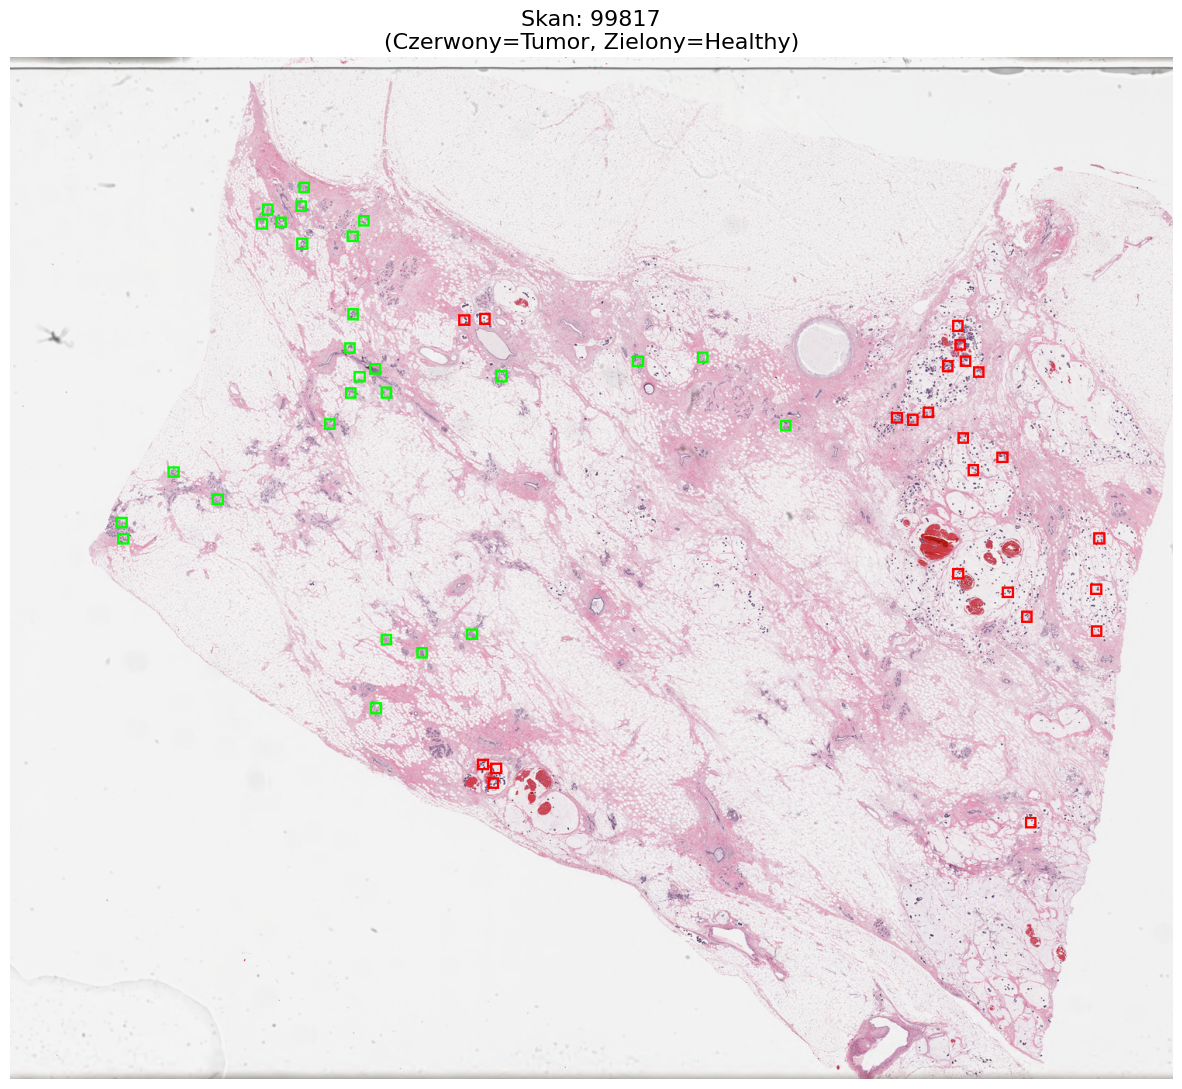

In [ ]:
# ====================================================================
#  KROK 1: IMPORTY
# ====================================================================
print("⏳ Instalowanie zależności...")
!apt-get install -y openslide-tools > /dev/null
!pip install openslide-python shapely -q
print("✅ Gotowe.")

import openslide
import xml.etree.ElementTree as ET
import re
import os
from google.colab import drive
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw

# ====================================================================
#  KROK 2: KONFIGURACJA
# ====================================================================

# 1. Wpisz ID skanu, który chcesz zwizualizować:
SCAN_ID_TO_VISUALIZE = "99817"  # <-- Dobry przykład, bo ma obie klasy

# 2. Wpisz nazwę folderu, w którym on się znajduje:
FOLDER_NAME_OF_SCAN = "WSI_train3"

# 3. Rozmiar miniatury (w pikselach). 1500 to dobra, czytelna wartość.
TARGET_THUMB_SIZE = (1500, 1500)

# --- Ścieżki (powinny być poprawne) ---
DATA_ROOT = "/content/drive/MyDrive/PKG-Post-NAT-BRCA"

# --- Konfiguracja (bez zmian) ---
CELLULARITY_REGEX = re.compile(r"(cellula.*:|tb-)\s*(\d+)")

# ====================================================================
#  KROK 3: FUNKCJE POMOCNICZE
# ====================================================================

def get_label_from_description(desc: str) -> str:
    """Interpretuje atrybut 'description' z pliku XML.
       Zwraca 'healthy', 'tumor' lub 'ignore'.
    """
    if not desc:
        return "ignore"
    desc = desc.lower()
    match = CELLULARITY_REGEX.search(desc)

    if match:
        try:
            cellularity = int(match.group(2))
            if cellularity == 0:
                return "healthy"
            elif cellularity > 0:
                return "tumor"
        except Exception:
            pass

    if "healthy" in desc or "normal epithelial" in desc:
        return "healthy"
    if "malignant" in desc or "idc" in desc or "dcis" in desc:
        return "tumor"
    return "ignore"

def parse_xml_for_drawing(xml_path: str, scale_factor: float) -> list:
    """
    Parsuje XML i zwraca listę przeskalowanych poligonów gotowych do rysowania.
    Zwraca: [ ([ (x1,y1), (x2,y2)... ], "etykieta"), ... ]
    """
    polygons_to_draw = []
    try:
        tree = ET.parse(xml_path)
        root = tree.getroot()
        for graphic in root.findall(".//graphic"):
            description = graphic.get("description")
            mapped_label = get_label_from_description(description)

            if mapped_label == "ignore":
                continue

            coordinates = []
            for coord in graphic.findall(".//point"):
                x = float(coord.text.split(',')[0])
                y = float(coord.text.split(',')[1])

                # --- KLUCZOWY KROK: Skalowanie współrzędnych ---
                scaled_x = x / scale_factor
                scaled_y = y / scale_factor
                coordinates.append((scaled_x, scaled_y))

            if len(coordinates) >= 3:
                polygons_to_draw.append((coordinates, mapped_label))

    except Exception as e:
        print(f"🟥 Błąd podczas parsowania XML {xml_path}: {e}")
    return polygons_to_draw

# ====================================================================
#  KROK 4: GŁÓWNA LOGIKA WIZUALIZACJI
# ====================================================================

def visualize_scan_with_annotations():

    print("Rozpoczynam wizualizację...")

    # 1. Montowanie Dysku Google
    try:
        drive.mount('/content/drive', force_remount=True)
    except Exception as e:
        print(f"🟥 BŁĄD: Nie udało się zamontować Dysku Google: {e}")
        return

    # 2. Zdefiniuj ścieżki
    scan_folder = os.path.join(DATA_ROOT, "WSI_train", FOLDER_NAME_OF_SCAN)
    scan_path = os.path.join(scan_folder, f"{SCAN_ID_TO_VISUALIZE}.svs")
    xml_path = os.path.join(scan_folder, "sedeen", f"{SCAN_ID_TO_VISUALIZE}.session.xml")

    if not os.path.exists(scan_path) or not os.path.exists(xml_path):
        print(f"🟥 BŁĄD: Nie znaleziono pliku .svs lub .xml dla skanu {SCAN_ID_TO_VISUALIZE}")
        return

    # 3. Wczytaj skan i stwórz miniaturę
    print("Wczytuję skan i tworzę miniaturę...")
    slide = openslide.open_slide(scan_path)
    full_dims = slide.level_dimensions[0]
    thumbnail = slide.get_thumbnail(TARGET_THUMB_SIZE)
    # Konwertujemy do RGB, aby móc rysować kolorowe linie
    thumbnail = thumbnail.convert("RGB")

    # 4. Oblicz współczynnik skalowania
    scale_factor = full_dims[0] / thumbnail.size[0]
    print(f"Pełna rozdzielczość: {full_dims}")
    print(f"Rozmiar miniatury: {thumbnail.size}")
    print(f"Współczynnik skali: {scale_factor:.2f}x")

    # 5. Wczytaj i przeskaluj poligony z XML
    print("Wczytuję i skaluję adnotacje XML...")
    polygons_to_draw = parse_xml_for_drawing(xml_path, scale_factor)
    print(f"Znaleziono {len(polygons_to_draw)} regionów ('healthy' i 'tumor') do narysowania.")

    # 6. Narysuj poligony na miniaturze
    draw = ImageDraw.Draw(thumbnail)

    # Definiujemy nasze kolory (R, G, B)
    color_map = {
        "healthy": (0, 255, 0),  # Zielony
        "tumor": (255, 0, 0)    # Czerwony
    }

    for points, label in polygons_to_draw:
        color = color_map.get(label)
        if color:
            # === ZMIANA TUTAJ ===
            # Rysujemy tylko kontur (outline) o grubości 3 pikseli
            # fill=None oznacza brak wypełnienia
            draw.polygon(points, fill=None, outline=color, width=3)
            # === KONIEC ZMIANY ===

    # 7. Wyświetl wynik
    print("✅ Gotowe. Wyświetlam obraz:")
    plt.figure(figsize=(15, 15))
    plt.imshow(thumbnail)
    plt.title(f"Skan: {SCAN_ID_TO_VISUALIZE}\n(Czerwony=Tumor, Zielony=Healthy)", fontsize=16)
    plt.axis('off')
    plt.show()

# ====================================================================
#  KROK 5: URUCHOMIENIE
# ====================================================================
if __name__ == "__main__":
    visualize_scan_with_annotations()